In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_BF
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.diagnostics import accuracy, expected_calibration_error

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tf.enable_eager_execution()

In [4]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [5]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [6]:
def beta_wide_prior(**args):
    
    return beta.rvs(1, 1)

def beta_sharp_prior(**args):
    
    return beta.rvs(30, 30)

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|boldsymbol{\theta},\boldsymbol{m}).$

In [7]:
def beta_model1(p, n_obs, **args):
    
    return np.random.binomial(n=1, p=p, size=(n_obs, 1))

def beta_model2(p, n_obs, **args):
    
    return np.random.binomial(n=1, p=p, size=(n_obs, 1))

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [8]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

## Marginal likelihood

In [9]:
def beta_binom(prior, x):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    
    alpha, beta = prior
    h = np.sum(x, axis=(1, 2))
    n = x.shape[1]
    p_x = np.exp(betaln(alpha + h, beta+n-h) - betaln(alpha, beta))
    return p_x

# Training hyperparameters (fixed N)

In [23]:
#--- Training hyperparameters ---#
n_obs = 100
n_test = 500
n_cal = 5000
alpha_smooth = None
epochs = 50
iterations_per_epoch = 1000
batch_size = 128
ckpt_file = 'toy_bf'

#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
decay_steps = 1000
decay_rate = .95

#--- Data generation ---#
model_names = ['Model 1', 'Model 2']
param_priors = [beta_wide_prior, beta_sharp_prior]
forward_models = [beta_model1, beta_model2]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs,
                   alpha_smooth=alpha_smooth)


# --- Optimizer --- #
global_step = tfe.Variable(0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Create test data and compute true BFs

In [11]:
%%time
test_data = data_gen(n_test)
test_data_c = data_gen(n_cal)

Wall time: 878 ms


In [12]:
priors = ((1, 1), (30, 30))
bf = beta_binom(priors[1], test_data['x'].numpy()) / beta_binom(priors[0], test_data['x'].numpy())

## Create model

In [24]:
model = DeepEvidentialModel(EVIDENTIAL_BF)

## Manage checkpoints

In [25]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/toy_bf\ckpt-12


## Train network

In [106]:
# Train current model
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        # Bayes factors
        m_probs = model(test_data['x'])['m_probs'].numpy()
        bf_hat = m_probs[:, 1] / m_probs[:, 0]

        f, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter(bf, bf_hat)
        ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel(r'True $BF_{10}$')
        ax.set_ylabel('Estimated $BF_{10}$')
        plt.show()
        
        
        n_chunks = 10
        test_data_c = data_gen(5000)
        preds = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                                for x in tf.split(test_data_c['x'], n_chunks, axis=0)], axis=0)


        plt.rcParams['font.size'] = 12
        f, ax = plt.subplots(1, 1, figsize=(8, 6))
        prob_true, prob_pred = calibration_curve(test_data_c['m'].numpy().argmax(axis=1), preds[:, 1])
        ax.plot(prob_true, prob_pred)
        ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('Accuracy')
        ax.set_ylabel('Confidence')
        plt.show()
    
        print(accuracy(test_data['m'], m_probs))
        manager.save()

## Evaluate

### Bayes factors

In [108]:
plt.rcParams['font.size'] = 12

Instructions for updating:
Colocations handled automatically by placer.


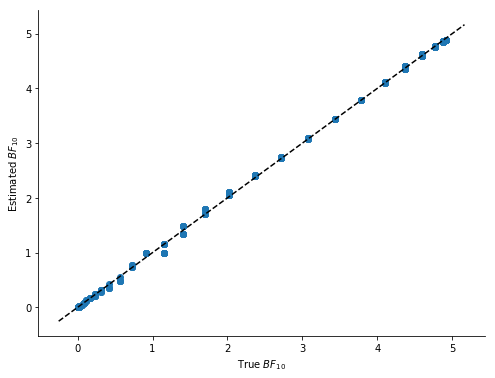

In [15]:
# Bayes factors
m_probs = model(test_data['x'])['m_probs'].numpy()
bf_hat = m_probs[:, 1] / m_probs[:, 0]

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bf, bf_hat)
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'True $BF_{10}$')
ax.set_ylabel('Estimated $BF_{10}$')
f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

### Calibration

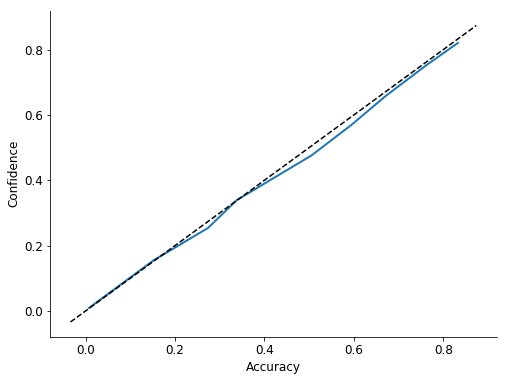

In [17]:
n_chunks = 10
test_data_c = data_gen(5000)
preds = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                        for x in tf.split(test_data_c['x'], n_chunks, axis=0)], axis=0)


plt.rcParams['font.size'] = 12
f, ax = plt.subplots(1, 1, figsize=(8, 6))
prob_true, prob_pred = calibration_curve(test_data_c['m'].numpy().argmax(axis=1), preds[:, 1], n_bins=10)
ax.plot(prob_true, prob_pred, lw=2)
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Confidence')
f.savefig('figures/Calibration_Toy.png', dpi=300, bbox_inches='tight')

# Training hyperparameters (var N)

In [43]:
#--- Training hyperparameters ---#
n_obs_min = 1
n_obs_max = 100
n_test = 500
n_cal = 5000
alpha_smooth = None
epochs = 50
iterations_per_epoch = 1000
batch_size = 128


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0001
decay_steps = 1000
decay_rate = .95

#--- Data generation ---#
model_names = ['Model 1', 'Model 2']
param_priors = [beta_wide_prior, beta_sharp_prior]
forward_models = [beta_model1, beta_model2]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max,
                   alpha_smooth=alpha_smooth)


# --- Optimizer --- #
global_step = tfe.Variable(0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Manage checkpoints

In [45]:
test_data = data_gen(n_test, n_obs=100)
ckpt_file = 'toy_bf_var_n'
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)

In [47]:
test_data = data_gen(n_test, n_obs=100)
priors = ((1, 1), (30, 30))
bf = beta_binom(priors[1], test_data['x'].numpy()) / beta_binom(priors[0], test_data['x'].numpy())

## Train network

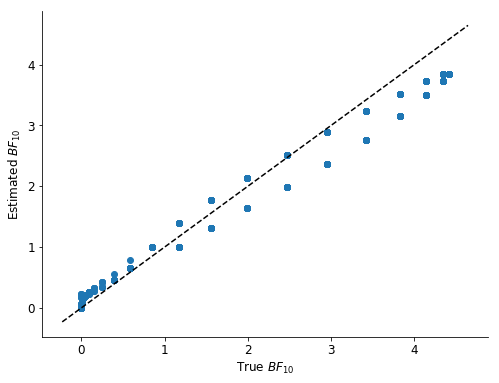

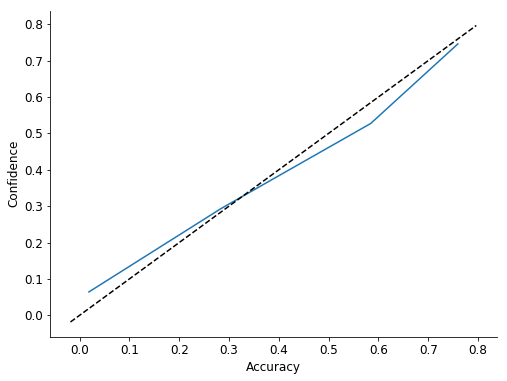

0.818



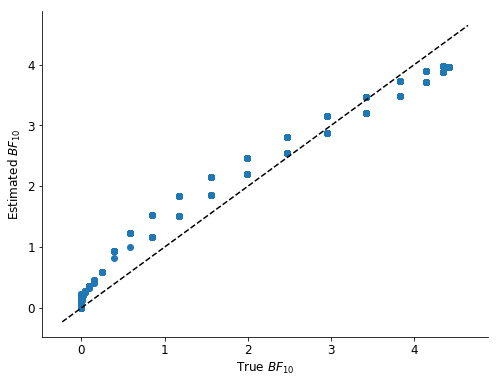

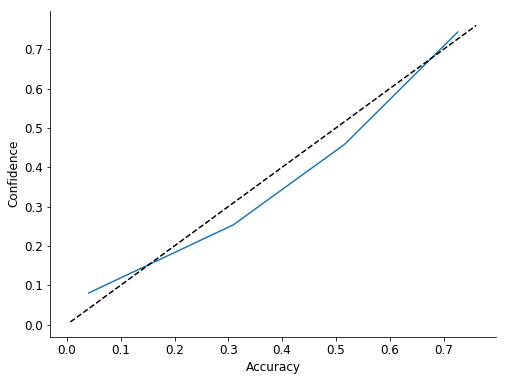

0.81



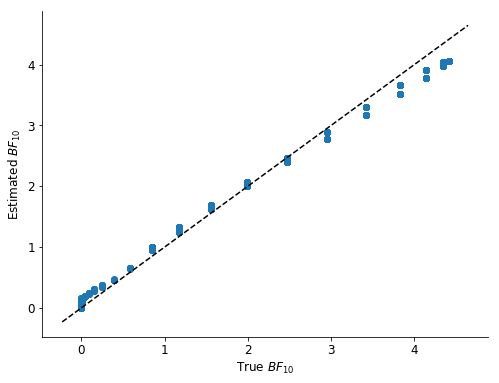

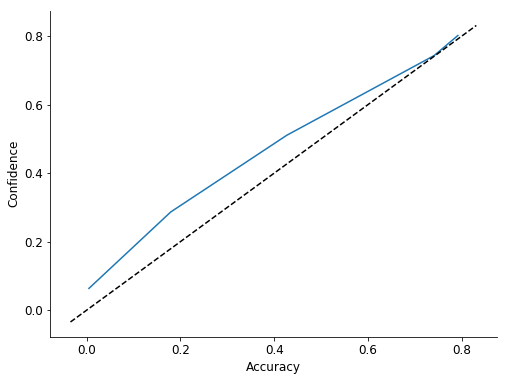

0.822



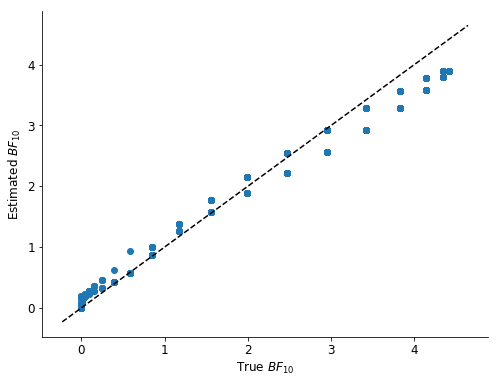

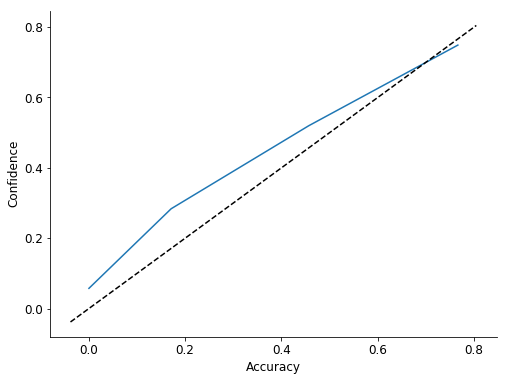

0.822



AttributeError: 'DType' object has no attribute 'type'

In [53]:
# Train current model
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        # Bayes factors
        m_probs = model(test_data['x'])['m_probs'].numpy()
        bf_hat = m_probs[:, 1] / m_probs[:, 0]

        f, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter(bf, bf_hat)
        ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel(r'True $BF_{10}$')
        ax.set_ylabel('Estimated $BF_{10}$')
        plt.show()
        
        
        n_chunks = 10
        test_data_c = data_gen(5000)
        preds = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                                for x in tf.split(test_data_c['x'], n_chunks, axis=0)], axis=0)


        plt.rcParams['font.size'] = 12
        f, ax = plt.subplots(1, 1, figsize=(8, 6))
        prob_true, prob_pred = calibration_curve(test_data_c['m'].numpy().argmax(axis=1), preds[:, 1])
        ax.plot(prob_true, prob_pred)
        ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('Accuracy')
        ax.set_ylabel('Confidence')
        plt.show()
    
        print(accuracy(test_data['m'], m_probs))
        manager.save()

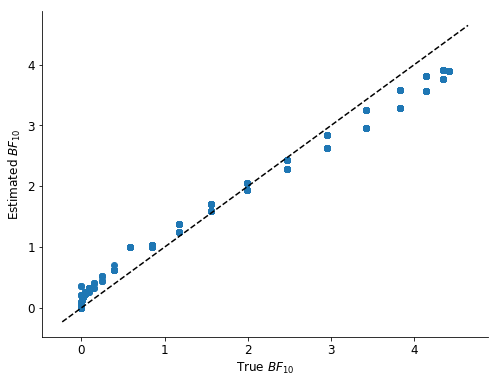

In [52]:
test_data = data_gen(n_test, n_obs=60)
priors = ((1, 1), (30, 30))
bf = beta_binom(priors[1], test_data['x'].numpy()) / beta_binom(priors[0], test_data['x'].numpy())

m_probs = model(test_data['x'])['m_probs'].numpy()
bf_hat = m_probs[:, 1] / m_probs[:, 0]

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bf, bf_hat)
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'True $BF_{10}$')
ax.set_ylabel('Estimated $BF_{10}$')
plt.show()